# Quantum Maze Solver

In [7]:
import qiskit
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np
from qiskit.circuit.library import GroverOperator
from maze_oracle import MazeOracle, MazeCircuitInfo
import sys
sys.path.insert(1, '../')
from utils import Helpers as hp
from maze_generator import Graph

In [8]:
Edge = tuple[int, int]

class Path(list[int]):
    def __init__(self, l: list[Edge]):
        super().__init__()
        if len(l) > 0:
            self.append(l[0][0])
        for e in l:
            self.append(e[1])

    def remove_cycles(self) -> 'Path':
        p = Path([])
        count = set()
        for x in self:
            if x in count:
                g = p.pop()
                while g != x:
                    count.discard(g)
                    g = p.pop()
            p.append(x)
            count.add(x)
        return p

    def __repr__(self):
        if len(self) > 0:
            s = [repr(e) for e in self]
            return '[' + str.join(' -> ', s) + ']'
        else:
            return '[]'
    def __hash__(self):
        return hash(repr(self))

class QuantumMazeCircuit(Graph, QuantumCircuit):
    def __init__(self, graph: Graph, max_path_length: int = None, turn_back_check: bool = False):
        self.__info = MazeCircuitInfo(graph, max_path_length)
        oracle = MazeOracle(self.__info, turn_back_check)
        

        QuantumCircuit.__init__(self, len(oracle.qubits), self.info.num_qubits_in_max_path) # init quantum circuit
        self.name = 'Maze Solver'
        diffuser = GroverOperator(QuantumCircuit(self.info.num_qubits_in_max_path))
        iterations = int(np.ceil( (np.pi / 4) * np.sqrt(self.info.num_qubits_in_max_path) ))
        for i in range(self.info.num_qubits_in_max_path):
            self.h(i)

        for i in range(iterations):
            self.barrier()
            self.append(oracle, range(len(oracle.qubits)))             # Apply oracle
            self.append(diffuser, range(self.info.num_qubits_in_max_path))    # Apply diffuser

    @property
    def info(self) -> int:
        return self.__info
    
    def __getattr__(self, name):
        return getattr(self.info.graph, name)


class QuantumMazeSolver:
    def generate_circuit(self, maze: Graph, max_path_length: int = None, turn_back_check: bool = False) -> QuantumMazeCircuit:
        return QuantumMazeCircuit(maze, max_path_length, turn_back_check)

    def __result_to_path(self, result: str, path_length: int, node_size: int) -> Path:
        path = []
        for i in range(path_length):
            offset = i*node_size
            n2 = int(result[offset : offset+node_size], 2)
            n1 = int(result[offset+node_size : offset+ 2*node_size], 2)
            path.insert(0, (n1, n2))
        return Path(path)

    def run(self, circuit: QuantumMazeCircuit, shots: int = 1) -> list[Path]:
        sim = AerSimulator()
        transpiled = transpile(circuit, sim)
        # Add measure to circuit
        transpiled.measure(range(len(circuit.clbits)), range(len(circuit.clbits)))
        # Run
        results = sim.run(transpiled, shots=shots, memory=True).result().get_memory()


        paths = [self.__result_to_path(r, circuit.info.max_path_length, circuit.info.bits_per_node) for r in results]
        return paths

    def solve(self, maze: Graph) -> Path:
        maze_circ = self.generate_circuit(maze)
        path = self.run(maze_circ, shots=1)
        return path[0]

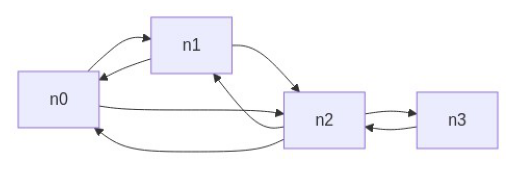

In [9]:
from maze_generator import BFSSolver, Graph, PrimGenerator
edges = [
    (0, 1),
    (1, 2),
    (0, 2),
    (2, 3),
]
graph = Graph.from_edges(edges, 0, 3, bidirectional=True)
graph.show()


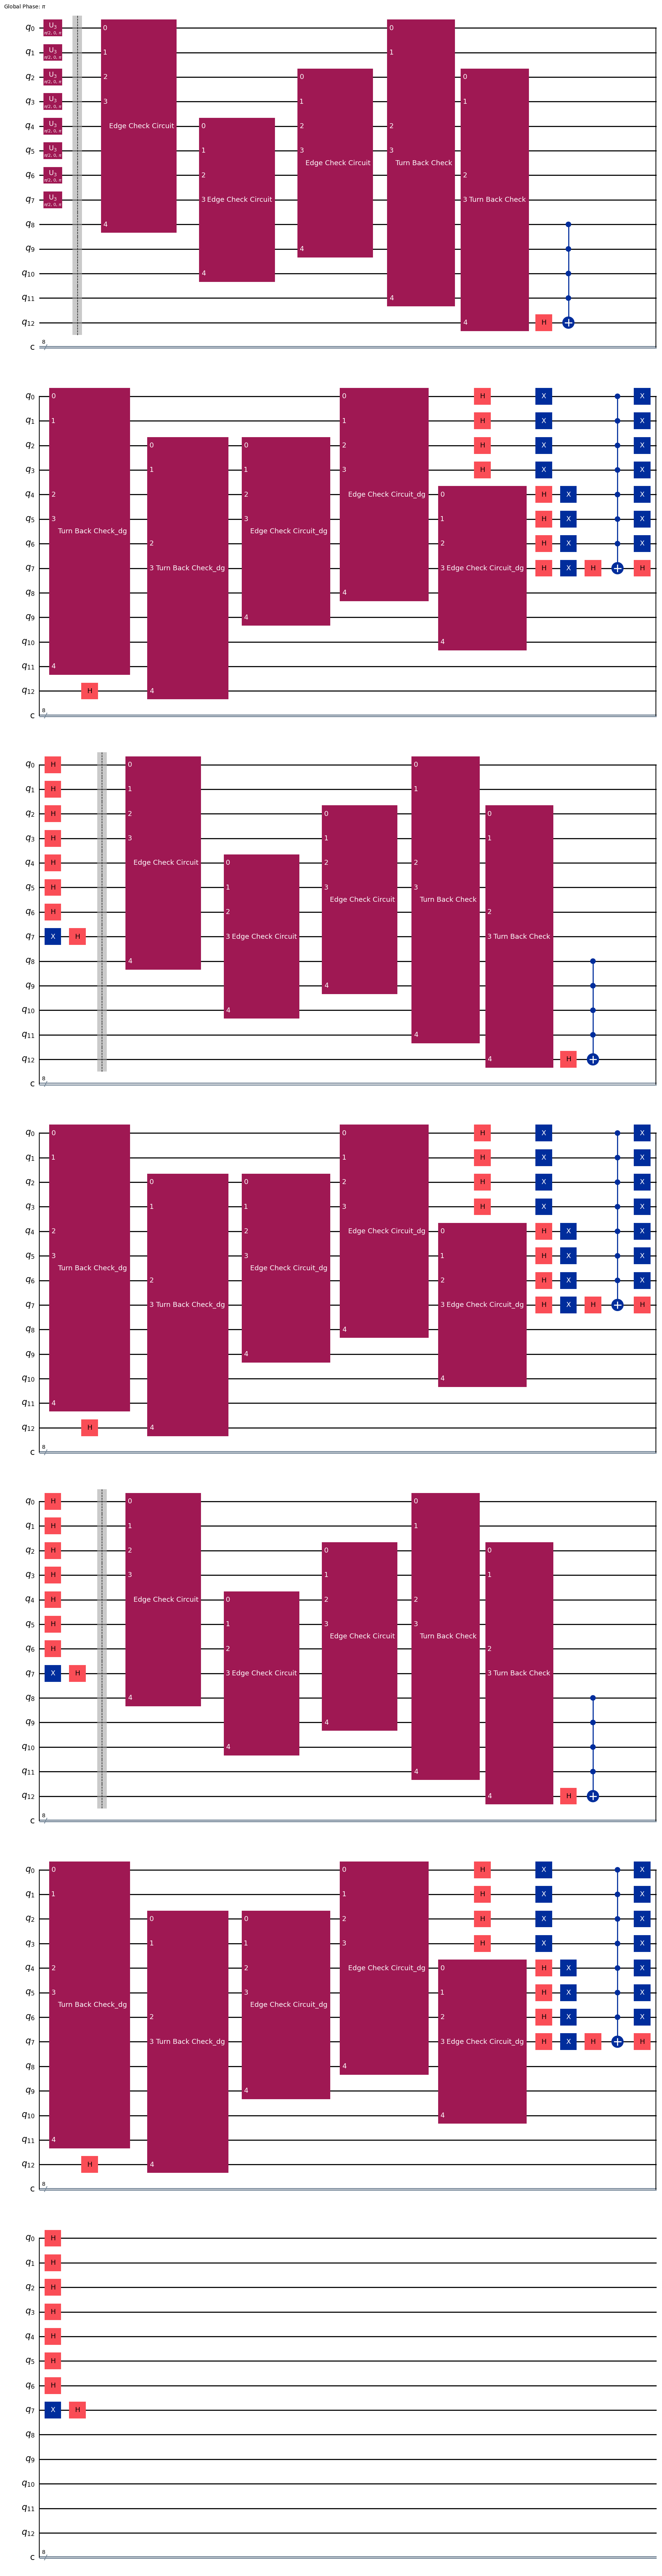

In [10]:
solver = QuantumMazeSolver()
qc = solver.generate_circuit(graph, turn_back_check=True)
qc.decompose(reps=2).draw('mpl')

In [11]:
result = solver.run(qc, shots=10000)
from collections import Counter
r = [print(k, ':', v) for k, v in sorted(Counter(result).items(), key=lambda x: -x[1])]

[0 -> 1 -> 2 -> 3] : 1735
[0 -> 2 -> 3 -> 3] : 1641
[1 -> 3 -> 0 -> 2] : 45
[3 -> 0 -> 1 -> 2] : 40
[0 -> 2 -> 2 -> 2] : 40
[3 -> 1 -> 2 -> 0] : 38
[3 -> 0 -> 0 -> 2] : 37
[1 -> 1 -> 0 -> 0] : 37
[3 -> 1 -> 1 -> 1] : 37
[3 -> 1 -> 3 -> 1] : 37
[0 -> 3 -> 0 -> 1] : 37
[3 -> 3 -> 2 -> 1] : 36
[3 -> 3 -> 3 -> 3] : 35
[1 -> 0 -> 1 -> 2] : 35
[3 -> 1 -> 1 -> 2] : 35
[2 -> 3 -> 2 -> 2] : 35
[1 -> 0 -> 3 -> 0] : 35
[0 -> 2 -> 3 -> 1] : 35
[2 -> 0 -> 1 -> 3] : 35
[2 -> 2 -> 1 -> 0] : 34
[3 -> 3 -> 0 -> 2] : 34
[2 -> 3 -> 0 -> 0] : 34
[2 -> 0 -> 2 -> 1] : 34
[0 -> 0 -> 2 -> 2] : 34
[2 -> 3 -> 3 -> 3] : 34
[3 -> 2 -> 0 -> 2] : 33
[3 -> 2 -> 1 -> 3] : 33
[3 -> 0 -> 2 -> 1] : 33
[3 -> 2 -> 3 -> 2] : 33
[0 -> 2 -> 2 -> 0] : 33
[0 -> 1 -> 1 -> 1] : 33
[1 -> 3 -> 2 -> 3] : 33
[1 -> 3 -> 1 -> 2] : 33
[0 -> 1 -> 1 -> 0] : 32
[3 -> 2 -> 1 -> 2] : 32
[0 -> 1 -> 0 -> 2] : 32
[2 -> 2 -> 3 -> 2] : 32
[1 -> 1 -> 3 -> 2] : 32
[3 -> 1 -> 2 -> 1] : 32
[2 -> 1 -> 3 -> 2] : 32
[0 -> 0 -> 3 -> 1] : 32
[0 -> 1 -> 3

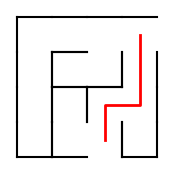

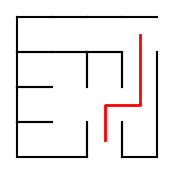

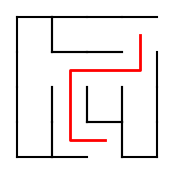

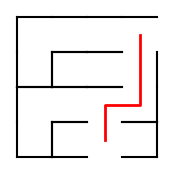

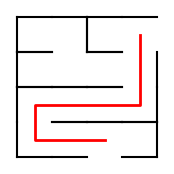

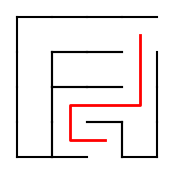

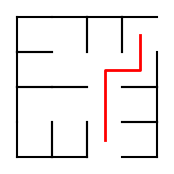

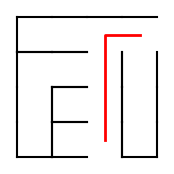

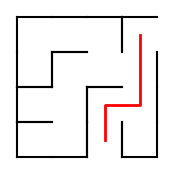

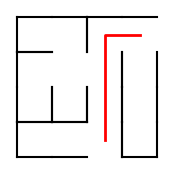

In [12]:
from maze_generator import BFSSolver, Graph, PrimGenerator
edges = [
    (0, 1),
    (0, 2),
    (1, 3),
    (2, 3),
    (2, 4),
    (3, 5),
]
maze_generator = PrimGenerator()
solver = BFSSolver()
# graph = Graph.from_edges(edges, bidirectional=True)
# graph.show(solver.solve_graph(graph, 0, 5))
for i in range(10):
    maze = maze_generator.generate_maze(4, 4, (3,0), (2,3))
    path = solver.solve_maze(maze)
    maze.show(path)
